In [ ]:
!pip install timm

In [ ]:
!pip uninstall opencv-python

In [ ]:
!pip uninstall opencv-contrib-python

In [ ]:
!pip install opencv-contrib-python==4.5.5.62

In [ ]:
!pip install torch_optimizer

In [ ]:
import os
import io
import zipfile
import shutil 
from pathlib import Path

import numpy as np 
import pandas as pd
import random

from tqdm import tqdm
import time
import copy

import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_optimizer as optimzr
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torchvision.datasets.folder import default_loader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau, StepLR
from torchsummary import summary

import albumentations as A
import albumentations.pytorch as AP
from albumentations import (Compose)

import timm

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# ====================================================
# CFG - класс с параметрами
# ====================================================
class CFG:
    num_workers=2
    model_name='mobilenetv3_large_100'
    size=224
    scheduler='StepLR'
    epochs=30
    step_size = 20 # StepLR
    gamma = 0.1 # StepLR
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    #T_max=6 # CosineAnnealingLR
    #T_0=6 # CosineAnnealingWarmRestarts
    lr=1e-4 # 3e-4
    min_lr=1e-6
    batch_size=32
    seed=42

In [ ]:
# Зафиксируем seed для воспроизводимости

def seed_everything(seed):
    random.seed(seed) # Фиксируем генератор случайных чисел
    os.environ['PYTHONHASHSEED'] = str(seed) # Фиксируем заполнения хешей
    np.random.seed(seed) # Фиксируем генератор случайных чисел numpy
    torch.manual_seed(seed) # Фиксируем генератор случайных чисел pytorch
    torch.cuda.manual_seed(seed) # Фиксируем генератор случайных чисел для GPU
    torch.backends.cudnn.deterministic = True # Выбираем только детерминированные алгоритмы (для сверток)
    torch.backends.cudnn.benchmark = False # Фиксируем алгоритм вычисления сверток

In [ ]:
# ==============================================================
# ImageFolderWithPaths - класс для создания путей до изображения
# ==============================================================

class ImageFolderWithPaths(datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [ ]:
# Функция для распаковки zip-архива

def unzip_data(zip_file, destination_dir):
    print('Data extraction started...', end='')
    with zipfile.ZipFile(zip_file, 'r') as zip_obj:
        zip_obj.extractall(destination_dir)
    print('done.')
    print(f'Files unzipped to \'{destination_dir}\'\n')

In [ ]:
# Функция сортировки изображений на train и valid

def make_train_valid_data():
    
    print('Copy pictures to Train and Valid groups started...', end='')
    for dir_name in [train_dir, valid_dir]:
        for class_name in class_names:
            os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

    for class_name in class_names:
        src_dir = os.path.join(data_root, 'train', class_name)
        files = os.listdir(src_dir)
        files = list(filter(lambda x: x.endswith('.jpg'), files)) + list(filter(lambda x: x.endswith('.JPG'), files))
        
        for i, file_name in enumerate(files):
            if i % 11 != 0:
                dst_dir = os.path.join(train_dir, class_name) 
            else:
                dst_dir = os.path.join(valid_dir, class_name)
            shutil.copy(os.path.join(src_dir, file_name), os.path.join(dst_dir, file_name))
    print('done.')

    # Отчет о том, правильно ли размещаются новые изображения
    for dir_name in [train_dir, valid_dir]:
        for class_name in class_names:
            dst_dir = os.path.join(dir_name, class_name)
            files = os.listdir(dst_dir)
            files = list(filter(lambda x: x.endswith('.jpg'), files)) + list(filter(lambda x: x.endswith('.JPG'), files))
            print(f'{len(files)} pictures copied to \'{dst_dir}\'')
    print()

In [ ]:
class_names = ['Bacterial_spot', 'Black_mold', 'Early_blight', 'Healthy', 'Late_blight', 'Mosaic_virus', 'Septoria_spot']
train_dir = 'train'
valid_dir = 'valid'

data_root = '/content/Tomato_leaf_diseases/'
!wget https://raw.githubusercontent.com/miksadikov/otus-deep_learning-final_project/master/Tomato_leaf_diseases.zip
unzip_data(zip_file='/content/Tomato_leaf_diseases.zip', destination_dir='/content/Tomato_leaf_diseases/train/')

Data extraction started...done.
Files unzipped to '/content/Tomato_leaf_diseases/train/'



In [ ]:
# Создаем train и valid датасеты
make_train_valid_data()

Copy pictures to Train and Valid groups started...done.
309 pictures copied to 'train/Bacterial_spot'
329 pictures copied to 'train/Black_mold'
361 pictures copied to 'train/Early_blight'
262 pictures copied to 'train/Healthy'
270 pictures copied to 'train/Late_blight'
317 pictures copied to 'train/Mosaic_virus'
347 pictures copied to 'train/Septoria_spot'
31 pictures copied to 'valid/Bacterial_spot'
33 pictures copied to 'valid/Black_mold'
37 pictures copied to 'valid/Early_blight'
27 pictures copied to 'valid/Healthy'
28 pictures copied to 'valid/Late_blight'
32 pictures copied to 'valid/Mosaic_virus'
35 pictures copied to 'valid/Septoria_spot'



In [ ]:
# ====================================================
# MakeDataset - класс для создания датасета
# ====================================================

class MakeDataset(torch.utils.data.Dataset):
    def __init__(self, files, transform=None):
        super().__init__()
        self.files = files           
        self.labels = [path.parent.name for path in self.files]
        self.len_ = len(self.files)
        self.transform = transform
        
    def __len__(self):
        return self.len_

    def __getitem__(self, index):
        image = cv2.imread(f'{self.files[index]}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
          augmented = self.transform(image=image)
          image = augmented['image']
        
        label = self.labels[index]
        if label == 'Bacterial_spot':
          y = 0
        if label == 'Black_mold':
          y = 1
        if label == 'Early_blight':
          y = 2
        if label == 'Healthy':
          y = 3
        if label == 'Late_blight':
          y = 4
        if label == 'Mosaic_virus':
          y = 5
        if label == 'Septoria_spot':
          y = 6
        return image, y

In [ ]:
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            A.Resize(224, 224),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            AP.ToTensorV2()])

    elif data == 'valid':
        return Compose([
            A.Resize(224, 224),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            AP.ToTensorV2()])

In [ ]:
TRAIN_DIR = Path('/content/train')
VAL_DIR = Path('/content/valid')

train_files = sorted(list(TRAIN_DIR.rglob('*.jpg'))) + sorted(list(TRAIN_DIR.rglob('*.JPG')))
val_files = sorted(list(VAL_DIR.rglob('*.jpg'))) + sorted(list(VAL_DIR.rglob('*.JPG')))

In [ ]:
train_dataset = MakeDataset(train_files, transform=get_transforms(data='train'))
val_dataset = MakeDataset(val_files, transform=get_transforms(data='valid'))

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(val_dataset, 
                              batch_size=CFG.batch_size**2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

print('Train and Valid datasets are loaded:\n')
print('{:<7s}{:>10s}{:>10s}'.format('Dataset', 'Batches', 'Pictures')), print('-' * 28)
print('{:<7s}{:>10d}{:>10d}'.format('Train', len(train_loader), len(train_dataset)))
print('{:<7s}{:>10d}{:>10d}'.format('Valid', len(valid_loader), len(val_dataset)))

Train and Valid datasets are loaded:

Dataset   Batches  Pictures
----------------------------
Train          68      2195
Valid           1       223


In [ ]:
def train_val_model(model, loss, optimizer, scheduler, num_epochs):
 
    loss_hist = {'train':[], 'val':[]}
    acc_hist = {'train':[], 'val':[]}
    
    best_acc = 0.

    seed_everything(CFG.seed)

    for epoch in range(num_epochs):
        print("Epoch {}/{}:".format(epoch+1, num_epochs), end="\n")
        for phase in ['train', 'val']:
            if phase == 'train': # Если фаза == train 
                dataloader = train_loader # Берем train_dataset
                scheduler.step() # Делаем 1 шаг (произошла одна эпоха)
                model.train()  # Модель в training mode - обучение (Фиксируем модель, иначе у нас могут изменяться параметры слоя батч-нормализации и изменится нейронка с течением времени)
            else: # Если фаза == val
                dataloader = valid_loader # Берем valid_dataset 
                model.eval()   # Модель в evaluate mode - валидация (Фиксируем модель, иначе у нас могут изменяться параметры слоя батч-нормализации и изменится нейронка с течением времени)
 
            running_loss = 0. 
            running_acc = 0.
 
            # Итерируемся по dataloader
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device) # Тензор с изображениями переводим на GPU 
                labels = labels.to(device) # Тензор с лейблами переводим на GPU 
 
                optimizer.zero_grad() # Обнуляем градиент,чтобы он не накапливался 
 
                with torch.set_grad_enabled(phase == 'train'): # Если фаза train, то активируем все градиенты
                    float_inputs = torch.tensor(inputs, dtype=torch.float)
                    preds = model(float_inputs) # Считаем предикты, input передаем в модель
                    loss_value = loss(preds, labels) # Посчитали  Loss    
                    preds_class = preds.argmax(dim=1) # Получаем класс, берем .argmax(dim=1) нейрон с максимальной активацией
                
                    if phase == 'train':
                        loss_value.backward() # Считаем градиент 
                        optimizer.step() # Считаем шаг градиентного спуска
 
                # Статистика
                running_loss += loss_value.item() # Считаем Loss
                running_acc += (preds_class == labels.data).float().mean().data.cpu().numpy()  # Считаем accuracy
 
            epoch_loss = running_loss / len(dataloader)  # Loss'ы делим на кол-во бачей в эпохе 
            epoch_acc = running_acc / len(dataloader) # Считаем Loss на кол-во бачей в эпохе            
               
            print("{} loss: {:.2f} accuracy: {:.2f}".format(phase, epoch_loss, epoch_acc), end="\n")

            if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc
              print(f'Epoch {epoch+1} - Save Best Accuracy: {best_acc:.2f} Model\n')
              torch.save(model.state_dict(), '/content/'+f'{CFG.model_name}_best.pth')
            
            loss_hist[phase].append(epoch_loss)
            acc_hist[phase].append(epoch_acc)
        
    return model, loss_hist, acc_hist

In [ ]:
class MyMobileV3Net(torch.nn.Module):
    def __init__(self, model_name='mobilenetv3_large_100', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)            
        
        # Добавляем полносвязанную голову
        self.model.classifier = torch.nn.Sequential(
          torch.nn.Linear(1280, 512),
          torch.nn.ReLU(),
          torch.nn.Linear(512, 7),
        )         

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
model = MyMobileV3Net(CFG.model_name, pretrained=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Определяем Loss функцию
# В данном случае - это кросс-энтропия 
loss = torch.nn.CrossEntropyLoss()
# Метод градиентного спуска AdamP
optimizer = optimzr.AdamP(model.parameters(), lr=CFG.lr) 

# Определяем разные типы изменения скорости обучения
def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
          scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='StepLR':
          scheduler = StepLR(optimizer, step_size=CFG.step_size, gamma=CFG.gamma)
        elif CFG.scheduler=='CosineAnnealingLR':
          scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
          scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

scheduler = get_scheduler(optimizer)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/mobilenetv3_large_100_ra-f55367f5.pth" to /root/.cache/torch/hub/checkpoints/mobilenetv3_large_100_ra-f55367f5.pth


In [ ]:
model, loss, acc = train_val_model(model, loss, optimizer, scheduler, num_epochs=CFG.epochs)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 1/30:


100%|██████████| 68/68 [00:18<00:00,  3.67it/s]


train loss: 1.28 accuracy: 0.64


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


val loss: 0.54 accuracy: 0.86
Epoch 1 - Save Best Accuracy: 0.86 Model

Epoch 2/30:


100%|██████████| 68/68 [00:11<00:00,  6.02it/s]


train loss: 0.34 accuracy: 0.89


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


val loss: 0.27 accuracy: 0.94
Epoch 2 - Save Best Accuracy: 0.94 Model

Epoch 3/30:


100%|██████████| 68/68 [00:11<00:00,  5.99it/s]


train loss: 0.15 accuracy: 0.95


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


val loss: 0.21 accuracy: 0.94
Epoch 3 - Save Best Accuracy: 0.94 Model

Epoch 4/30:


100%|██████████| 68/68 [00:11<00:00,  5.93it/s]


train loss: 0.07 accuracy: 0.98


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


val loss: 0.22 accuracy: 0.94
Epoch 5/30:


100%|██████████| 68/68 [00:11<00:00,  5.95it/s]


train loss: 0.04 accuracy: 0.99


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


val loss: 0.21 accuracy: 0.94
Epoch 6/30:


100%|██████████| 68/68 [00:11<00:00,  5.92it/s]


train loss: 0.03 accuracy: 0.99


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


val loss: 0.21 accuracy: 0.93
Epoch 7/30:


100%|██████████| 68/68 [00:11<00:00,  5.85it/s]


train loss: 0.02 accuracy: 1.00


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


val loss: 0.23 accuracy: 0.95
Epoch 7 - Save Best Accuracy: 0.95 Model

Epoch 8/30:


100%|██████████| 68/68 [00:11<00:00,  5.87it/s]


train loss: 0.01 accuracy: 1.00


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


val loss: 0.25 accuracy: 0.95
Epoch 9/30:


100%|██████████| 68/68 [00:11<00:00,  5.87it/s]


train loss: 0.02 accuracy: 0.99


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


val loss: 0.24 accuracy: 0.93
Epoch 10/30:


100%|██████████| 68/68 [00:11<00:00,  5.93it/s]


train loss: 0.02 accuracy: 0.99


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


val loss: 0.24 accuracy: 0.94
Epoch 11/30:


100%|██████████| 68/68 [00:11<00:00,  5.93it/s]


train loss: 0.01 accuracy: 1.00


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


val loss: 0.24 accuracy: 0.95
Epoch 12/30:


100%|██████████| 68/68 [00:11<00:00,  5.90it/s]


train loss: 0.01 accuracy: 1.00


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


val loss: 0.25 accuracy: 0.94
Epoch 13/30:


100%|██████████| 68/68 [00:11<00:00,  5.90it/s]


train loss: 0.01 accuracy: 1.00


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


val loss: 0.26 accuracy: 0.94
Epoch 14/30:


100%|██████████| 68/68 [00:11<00:00,  5.87it/s]


train loss: 0.01 accuracy: 1.00


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


val loss: 0.26 accuracy: 0.94
Epoch 15/30:


100%|██████████| 68/68 [00:11<00:00,  5.89it/s]


train loss: 0.01 accuracy: 1.00


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


val loss: 0.34 accuracy: 0.93
Epoch 16/30:


100%|██████████| 68/68 [00:11<00:00,  5.93it/s]


train loss: 0.01 accuracy: 0.99


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


val loss: 0.33 accuracy: 0.93
Epoch 17/30:


100%|██████████| 68/68 [00:11<00:00,  5.92it/s]


train loss: 0.01 accuracy: 1.00


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


val loss: 0.34 accuracy: 0.92
Epoch 18/30:


100%|██████████| 68/68 [00:11<00:00,  5.90it/s]


train loss: 0.01 accuracy: 1.00


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


val loss: 0.31 accuracy: 0.93
Epoch 19/30:


100%|██████████| 68/68 [00:11<00:00,  5.83it/s]


train loss: 0.01 accuracy: 1.00


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


val loss: 0.31 accuracy: 0.94
Epoch 20/30:


100%|██████████| 68/68 [00:11<00:00,  5.74it/s]


train loss: 0.00 accuracy: 1.00


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


val loss: 0.30 accuracy: 0.95
Epoch 21/30:


100%|██████████| 68/68 [00:11<00:00,  5.88it/s]


train loss: 0.00 accuracy: 1.00


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


val loss: 0.29 accuracy: 0.95
Epoch 22/30:


100%|██████████| 68/68 [00:11<00:00,  5.89it/s]


train loss: 0.00 accuracy: 1.00


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


val loss: 0.31 accuracy: 0.93
Epoch 23/30:


100%|██████████| 68/68 [00:11<00:00,  5.84it/s]


train loss: 0.00 accuracy: 1.00


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


val loss: 0.28 accuracy: 0.94
Epoch 24/30:


100%|██████████| 68/68 [00:11<00:00,  5.87it/s]


train loss: 0.00 accuracy: 1.00


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


val loss: 0.28 accuracy: 0.94
Epoch 25/30:


100%|██████████| 68/68 [00:11<00:00,  5.89it/s]


train loss: 0.00 accuracy: 1.00


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


val loss: 0.29 accuracy: 0.93
Epoch 26/30:


100%|██████████| 68/68 [00:11<00:00,  5.82it/s]


train loss: 0.00 accuracy: 1.00


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


val loss: 0.33 accuracy: 0.93
Epoch 27/30:


100%|██████████| 68/68 [00:11<00:00,  5.81it/s]


train loss: 0.00 accuracy: 1.00


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


val loss: 0.31 accuracy: 0.94
Epoch 28/30:


100%|██████████| 68/68 [00:11<00:00,  5.83it/s]


train loss: 0.00 accuracy: 1.00


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


val loss: 0.31 accuracy: 0.94
Epoch 29/30:


100%|██████████| 68/68 [00:11<00:00,  5.88it/s]


train loss: 0.00 accuracy: 1.00


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


val loss: 0.30 accuracy: 0.93
Epoch 30/30:


100%|██████████| 68/68 [00:11<00:00,  5.85it/s]


train loss: 0.00 accuracy: 1.00


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

val loss: 0.33 accuracy: 0.93


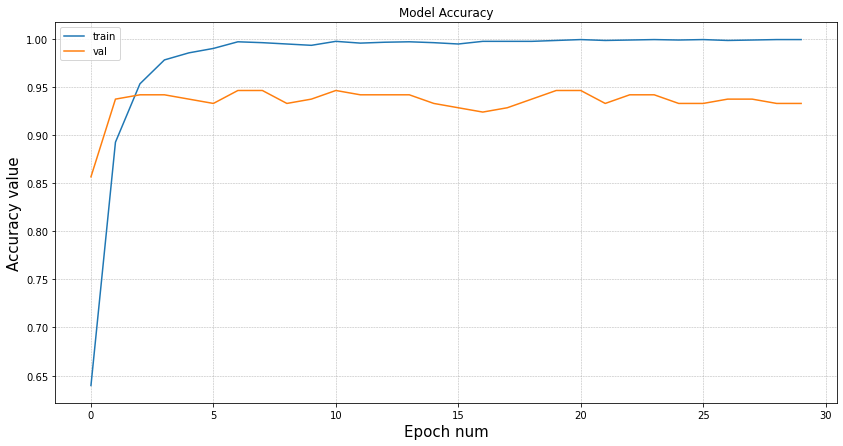

In [ ]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc.keys():
    plt.plot(acc[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')

In [ ]:
# Загружаем предварительно сохраненную модель
device = torch.device('cpu')
model = MyMobileV3Net(CFG.model_name, pretrained=False)
!wget 'https://raw.githubusercontent.com/miksadikov/otus-deep_learning-final_project/master/mobilenetv3_large_100_best.pth'
model.load_state_dict(torch.load('/content/mobilenetv3_large_100_best.pth', map_location=torch.device('cpu')))
model.eval()
model.to(device)

MyMobileV3Net(
  (model): MobileNetV3(
    (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): Hardswish()
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (bn1): BatchNormAct2d(
            16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (se): Identity()
          (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNormAct2d(
            16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Identity()
          )
          (drop_path): Iden

In [ ]:
pred_transforms = Compose([
    A.Resize(224, 224),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    AP.ToTensorV2()])

In [ ]:
# Функция для предсказания
def predict_image(image):
    image_tensor = pred_transforms(image=image)["image"].unsqueeze(0)
    image_tensor = torch.tensor(image_tensor, dtype=torch.float)
    input = image_tensor.to(device)
    outputs = model(input)
    _, preds = torch.max(outputs, 1)
    prob = F.softmax(outputs, dim=1)
    top_p, top_class = prob.topk(1, dim=1)
    fig, ax = plt.subplots()
    ax.set_title('predicted class: {}\n score: {}'.format(class_names[int(preds.cpu().numpy())], round(top_p.detach().cpu().numpy().tolist()[0][0],2)))
    plt.imshow(image)  
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


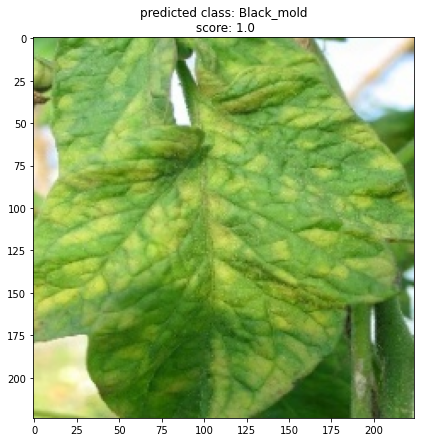

In [ ]:
!wget https://raw.githubusercontent.com/miksadikov/otus-deep_learning-final_project/master/black_mold.jpg
image_path = "/content/black_mold.jpg"

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predict_image(image)